## Diffusion equation solution

In [320]:
%reset -f
import numpy as np
from LebedevHelper import *

import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
%matplotlib notebook

ticksize= 12
titlesize = 18
mpl.rcParams.update({'font.size':ticksize }) # legend
mpl.rcParams.update({'ytick.labelsize':ticksize })
mpl.rcParams.update({'xtick.labelsize':ticksize})
mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize':titlesize})
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-4,4]})
mpl.rcParams.update({'figure.figsize':[6,5]})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams.update({'image.cmap':'rainbow'})

mpl.rcParams.update({'axes.formatter.useoffset':True})   # False ->no offset of axis
mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4 

np.set_printoptions(precision=3,suppress=True) 
plt.close('all')

In [516]:
pi2 = 2*np.pi
eps = 1e-2

a = 1e-3
b = 0
g = 0.02
g2 = g/2 


def trapezoidal(x,y,bool_center=0):
    if bool_center:
        dx = np.diff(x)[0]
        return np.sum(dx*y)
    else:
        return np.sum(np.diff(x)*(y[1:]+y[:-1]))*0.5

def simp(x,y,bool_center=0):
    if bool_center:
        print('CANNOT CALCULATE')
        return np.nan
    else:
        rest = (np.size(x)-1)%2
        dx = np.diff(x)[0]
        add=0
        if rest>0:
            print('N is even, simplify for last point')
            add = dx*0.5 * (y[-1]+y[-2])
            y = y[:-rest]

        return dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])+add

def edge_to_center(r):
    return 0.5*(r[1:]+r[:-1])


def DD(r,Dnr,Deq=1,Dibs=0,Jxavg = 1):
    D = np.zeros_like(r)
    
    if Dnr == 1:
        D = Deq*np.ones_like(r)
    elif Dnr == 2:
        dq = a * (0.5*r**2-Jxavg)
        dmu = pi2*dq
        c2 = (1-g2) 
        c3 = g2**2
        D = Deq * c2**2*dmu**2 / (c3 + c2*dmu**2)
    elif Dnr == 3:
        dq = a * (0.5*r**2-Jxavg)
        D = Deq * pi2**2*(1-g2)**2*(dq)**2 / (pi2**2*(1-g2)*(dq)**2  + g2**2)
    elif Dnr == 4:
        q = a * (0.5*r**2)
        JxDres = 1
        Jxavg = 3
        QIns = a * JxDres
        varQ2= 2*(0.4*a)**2
        D = DD(r,2,Deq,Jxavg)* (1+10*np.exp(-(q-QIns)**2/varQ2))
    elif Dnr ==5:
        # constant diffusion for J
        D = (Deq+Dibs)*2

    else:
        print('This Diffusion coefficient is not implemented')
    return D+Dibs

def derDD(r,Dnr,Deq=1,Jxavg=1):
    derD = np.zeros_like(r)

    if Dnr == 1:
        derD[:] = 0
    elif Dnr == 2 :
        dq    = a * (0.5*r**2-Jxavg)
        ddqdr = a * (r)
        dmu   = pi2*dq
        ddmudr= pi2*ddqdr
        c2 = (1-g2) 
        c3 = g2**2
        derD[:] = Deq * c2**2 * c3 * 2*dmu/(c3 + c2*dmu**2)**2 * ddmudr
    elif Dnr==3:
        dq1 = (0.5*(r+eps)**2 -1)*a
        dq2 = (0.5*(r-eps)**2 -1)*a
        derD[:] = Deq * (pi2**2*(1-g2)**2*(dq1)**2 / (pi2**2*(1-g2)*(dq1)**2  + g2**2) \
                      -pi2**2*(1-g2)**2*(dq2)**2 / (pi2**2*(1-g2)*(dq2)**2  + g2**2)) / (2*eps) 
    elif Dnr==4:
        derD[:] = (DD(r+eps,Dnr,Deq,Dibs,Jxavg)-DD(r-eps,Dnr,Deq,Dibs,Jxavg))/(2*eps)
    elif Dnr ==5:
        # constant diffusion for J
        derD *= 0
        
    else:
        print('This Diffusion coefficient is not implemented')
    
    return derD

def preDers(r,Dnr,Deq,Dibs,bool_timeDependent=False,psi=0):
    Jxavg = 1
    if bool_timeDependent:
        Jxavg = trapezoidal(r,0.5*r**2 *r*psi)
#         print('Avg Jx = %.2f'%Jxavg)
    
    preDer2 = DD(r,Dnr,Deq,Dibs,Jxavg) + Dibs
    
    
    preDer1a = derDD(r,Dnr,Deq,Jxavg)
    if r[0]==0:
#         preDer1b = np.concatenate(([0],preDer2[1:]/r[1:]))
        preDer1b = np.concatenate(([preDer2[1]/r[1]],preDer2[1:]/r[1:]))
    else:
        preDer1b = preDer2/r
    preDer1 = preDer1a + preDer1b

    preDer1 = preDer1[:,np.newaxis]  ; preDer2 = preDer2[:,np.newaxis]  
    return preDer1, preDer2 , preDer1a , preDer1b


def plot_preDers(r,Dnr,Deq,Dibs,bool_timeDependent=False,psi=0):
    preDer1,preDer2,derD,_ = preDers(r,Dnr,Deq,Dibs,bool_timeDependent,psi)
        
    plt.figure(3)
    # plt.plot(r,preDer2,label='D*')
    plt.plot(r,preDer2,label='D')
    plt.plot(r,preDer1,label='dD/dr')
    plt.legend()
    
    plt.plot(r,preDer2*S_Cummel(r[1]-r[0],preDer1,preDer2),'--')
    
# def limit(r,psi):
#     limiter = np.zeros_like(r)
#     diff = np.diff(psi)
#     ratio = np.abs
    
def limiter(psi,dr=1,dt=1,Deq=1):
    diff  = np.abs(np.concatenate(([0],np.diff(psi),[0])))
    diff = 200*(diff[1:]+diff[:-1])/dr*dt*Deq
#     diff = (diff[1:]/diff[:-1])
    return np.exp(-diff**2)[:,np.newaxis]

def S_Cummel_P(P):
    return (1.+ P-1+2*P/(np.exp(2*P)-1))

def S_Cummel(dr,preDer1,preDer2,method=1):
    P = np.abs(dr*preDer1/(2*preDer2))
    if method==1:
        return (1.+ P-1+2*P/(np.exp(2*P)-1))
    else:
        return (1.+ P)#-1+2*P/(np.exp(2*P)-1))


In [502]:
# Boundary conditions
# def dirchlet(A,b,side,val):
#     if side==1: #Right side
#         b+=A[-1,:]*val
# def homNeumann()

def dirichlet(M,side):
    if side == 0:
        M[0,:]  = 0
    if side == 1:
        M[-1,:] = 0
    return M

def homNeumann(M1,M2,side):
    if side == 0:
        M1[0,:]=0
        M2[0,1] = 2*M2[0,1]
    elif side ==1:
        M1[-1,:]=0
        M2[-1,-2] = 2*M2[-1,-2]
    return M1,M2

<IPython.core.display.Javascript object>


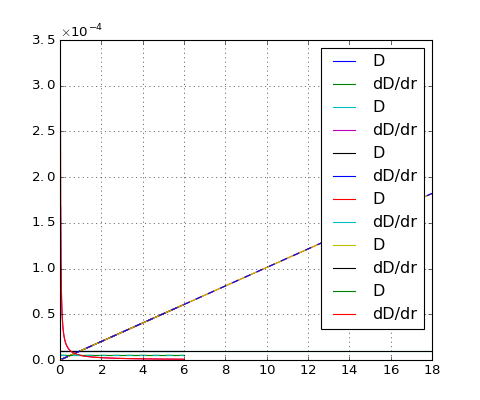

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:140: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:142: RuntimeWarning: invalid value encountered in true_divide


In [503]:
Dnr = 5
plot_preDers(r,Dnr,Deq,Dibs,0)
# plot_preDers(r,Dnr,Deq,Dibs,1,psi)
# P = np.abs(dr*preDer1/(2*preDer2))
# plt.plot(r,P)
plt.grid(True)

Deq  5.06025e-06
Dibs 0.0
dt   1630.18867925
nt   54
tmax 24.0
tmaxODE 24.0
1/(1+2Dt) 0.5335008668322084
None
TEST (201,) (200, 200)


<IPython.core.display.Javascript object>


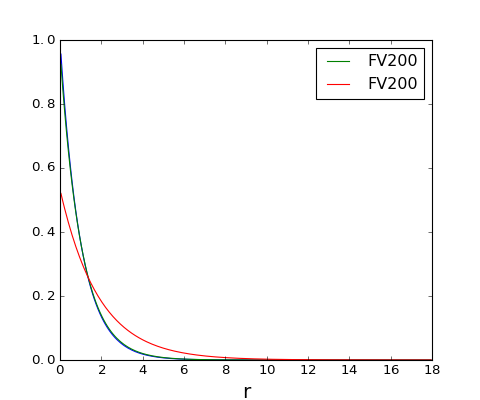

[     0.   3600.   7200.  10800.  14400.  18000.  21600.  25200.  28800.
  32400.  36000.  39600.  43200.  46800.  50400.  54000.  57600.  61200.
  64800.  68400.  72000.  75600.  79200.  82800.  86400.]
[ 0.521  0.496  0.473  0.451] [ 0.  0.  0.  0.]
[  0.     0.09   0.18   0.27   0.36   0.45   0.54   0.63   0.72   0.81
   0.9    0.99   1.08   1.17   1.26   1.35   1.44   1.53   1.62   1.71
   1.8    1.89   1.98   2.07   2.16   2.25   2.34   2.43   2.52   2.61
   2.7    2.79   2.88   2.97   3.06   3.15   3.24   3.33   3.42   3.51
   3.6    3.69   3.78   3.87   3.96   4.05   4.14   4.23   4.32   4.41
   4.5    4.59   4.68   4.77   4.86   4.95   5.04   5.13   5.22   5.31
   5.4    5.49   5.58   5.67   5.76   5.85   5.94   6.03   6.12   6.21
   6.3    6.39   6.48   6.57   6.66   6.75   6.84   6.93   7.02   7.11
   7.2    7.29   7.38   7.47   7.56   7.65   7.74   7.83   7.92   8.01
   8.1    8.19   8.28   8.37   8.46   8.55   8.64   8.73   8.82   8.91   9.
   9.09   9.18   9.27   9.36   9.

In [530]:
bool_Dirichlet = 0
bool_timeDependentDiffCoeff = 0
bool_IncoNoise = 0
bool_conservative = 0
bool_smooth    = 0
smoothFac      = 0.9999
iteration_scheme = 5 #[explicit euler, implicit euler, crank nicholson]
discretization_scheme = 2 #[0,FD, FV]
bool_limitFV = 0
Dnr = 5 # [0,Constant, Lebedev]
bool_plotOnce = 1
#################################
### Initiate Space Separation ###
L = 6
if Dnr == 5:
    L = .5*L**2
Nr = 201
r = np.linspace(0,L,Nr)
dr= np.diff(r)[0]
if discretization_scheme==2:
    # Finite volume
    Ne = Nr
    Nr = Ne-1
    rEdge = r
    r = edge_to_center(rEdge)
    

f_lhc = 11245 *1
noise = 3e-5
Deq=0.5*noise**2*f_lhc # Coherent diffusion noise 
# Deq = 1
Dibs = Deq*0.001*bool_IncoNoise        # Incoherent diffusion noise: Intra beam scattering


print('Deq ',Deq)
print('Dibs',Dibs)



################################
#### Initiate time iteration ###
C = 1
dt = C*dr**2/Deq
# CFL = 1
# dt= CFL*dr/np.max(preDer1)
# print('CFL',np.max(preDer1)*dt/dr)
tmaxODE=24*3600
tmax = min(tmaxODE,15000*dt)  
# tmax = 24*3600
nt = int(np.ceil(tmax/dt))
ts = np.linspace(0,tmax,nt)
tsode = np.linspace(0,tmaxODE,25)
dt = np.diff(ts)[0]
sig=1


print('dt  ',dt)
print('nt  ',nt)
print('tmax',tmax/3600)
print('tmaxODE',tmaxODE/3600)
print('1/(1+2Dt)',1/(1+2*(Deq+Dibs)*tmaxODE))

# Initial distribution
# if discretization_scheme==1:
psi0  =1/sig**2*np.exp(-0.5*r**2/sig**2)
if Dnr==5:
    psi0 = 1/sig*np.exp(-r/sig)
psis = np.zeros((nt,Nr))
psi = psi0
# elif discretization_scheme==2:
#     psi0FV=1/sig**2*np.exp(-0.5*r**2/sig**2)
#     psis = np.zeros((nt,Nc))
#     psi = psi0FV
    
psis[0,:]=psi

#################################
### Finish Space Separation ###
# Finite difference:
if discretization_scheme==1:
    upwind = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
    dnwind = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
    upwind2= ( 3*np.eye(Nr) -4*np.eye(Nr,k=-1)+np.eye(Nr,k=-2))/(2*dr)
    dnwind2= (-3*np.eye(Nr) +4*np.eye(Nr,k=1) -np.eye(Nr,k=2))/(2*dr)
    upwind2[:2,:2]  =upwind[:2,:2] ; dnwind2[-2:,-2:]=dnwind[-2:,-2:]
    centered=(np.eye(Nr,k=1)-np.eye(Nr,k=-1))/(2*dr)
    
    preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,0)[:2]
    vp = (preDer1<0)
    vm = (preDer1>0)


    # der1 = (upwind *vp + dnwind *vm)
    # der1 = (upwind2*vp + dnwind2*vm)
    der1= centered 
    # preDer1 = preDer1/S_Cummel(dr,preDer1,preDer2,2)
    # print(S_Cummel(dr,preDer1,preDer2,1))
    print(preDer1.T)
    if np.any(preDer2==0):
        print("OBS: Zero diffusion")
        preDer2[preDer2==0]+=1e-9
    print(S_Cummel(dr,preDer1,preDer2,1).T)
    preDer2 = preDer2*S_Cummel(dr,preDer1,preDer2,1)
    der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**2)




    # der1a = (np.eye(Nr) + np.eye(Nr,k= 1))/(2*dr)
    # der1b =-(np.eye(Nr) + np.eye(Nr,k=-1))/(2*dr)
    # A1 = der1a*(v[1:,np.newaxis]) + der1b*(v[:-1,np.newaxis])


    if 0:
        Jxavg=1
        redge = r[:-1]+np.diff(r)*0.5
        preDer1Edge = derDD(redge,Dnr,Deq,Jxavg) + DD(redge,Dnr,Deq,Dibs,Jxavg)/redge
        v = np.concatenate(([0],-preDer1Edge,[0]))
        vp = v>=0
        vn = v<0
        vvp=(v*vp)[np.newaxis,1:]
        vvm=(v*vn)[np.newaxis,:-1]
        vvp=(v*vp)[1:,np.newaxis]
        vvm=(v*vn)[:-1,np.newaxis]
        flux2 = -(upwind)*(vvp) \
                -(dnwind)*(vvm)
        A1 = flux2





    # A1 = preDer1*(preDer1>0)*upwind + preDer1*(preDer1<0)*dnwind


    A1 = preDer1*der1
    A2 = preDer2*der2
    homNeumann(A1,A2,0)
    homNeumann(A1,A2,1)
    homNeumann(der1,der2,0)
    homNeumann(der1,der2,1)
    
    # A = preDer1*der1 + preDer2*der2
    A = A1+ A2

elif discretization_scheme==2:
    # Finite volume
    der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
    der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
    der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**1)
    
      
    coeffEdge=-rEdge*DD(rEdge,Dnr,Deq,Dibs)
    
#     if not bool_Dirichlet: #Neumann
#         coeffEdge[-1]=0
#     elif bool_Dirichlet: #Dirichlet
#         coeffEdge[-2]=0
    FVRe = -coeffEdge[1:,np.newaxis]*der1R
    FVLe = -coeffEdge[:-1,np.newaxis]*der1L

    FVD = 0
    if bool_limitFV:
        aa=coeffEdge[1:,np.newaxis]
        bb=coeffEdge[:-1,np.newaxis]
        P = (bb-aa)/(bb+aa)
        FVD = +(0.5*(aa+bb)*(S_Cummel_P(P)-1))*der2
#         R = np.diff(psi0)[:-1]/np.diff(psi0)[1:]
    
    FV = (FVRe-FVLe +FVD)/ (dr*r[:,np.newaxis])  
    if Dnr==5:
        FV = (FVRe-FVLe +FVD)/ (dr)
        
    if not bool_Dirichlet: #Neumann
        print('None')
        FV[-1,-1]=-FV[-1,-2]
    if bool_Dirichlet: #Dirichlet
        FV[-1,:]=0
    
    print('TEST',coeffEdge.shape,der1L.shape)
    

if bool_plotOnce:
    plt.figure(6)
    plt.xlabel('r')


#################
### Iteration ###
if discretization_scheme==1:
    if bool_Dirichlet:
        A1 = dirichlet(A1,1)
        A2 = dirichlet(A2,1)
        A = A1+A2

    I    = np.eye(Nr)
    IE_A = I-dt*A
    CN_A = I-0.5*dt*(A1+A2)
    CN_B = I+0.5*dt*(A1+A2)

    # A1 = preDer1*der1
    limit = limiter(psi,dr,dt,Deq)
    S_A=I-0.5*dt*(A2+A1*limit)
    S_B=I+0.5*dt*(A2+A1*limit)

    
    def dpsidt(psi,t,r,A1=A1,A2=A2):
        if bool_timeDependentDiffCoeff:
            preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,True,psi)[:2]

            #Add numerical viscosity
            if np.any(preDer2==0):
                print("OBS: Zero diffusion")
                preDer2[preDer2==0]+=1e-9
            preDer2 = preDer2*S_Cummel(dr,preDer1,preDer2,1)

            A1 = preDer1*der1 ; A2 = preDer2*der2
            if bool_Dirichlet:
                A1 = dirichlet(A1,1)
                A2 = dirichlet(A2,1)
        return (A1+A2).dot(psi)
elif discretization_scheme ==2:
    def dpsidtFV(psi,t,r,A=FV):
        return A.dot(psi)

if iteration_scheme!=5:
    for i,t in enumerate(ts):
        if i>0:
            # Update D,dD/dr,D/r
            if bool_timeDependentDiffCoeff:
                preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,True,psi)[:2]
                A1 = preDer1*der1 ; A2 = preDer2*der2
                if bool_Dirichlet:
                    A1 = dirichlet(A1,1)
                    A2 = dirichlet(A2,1)
                A = A1+A2

                I    = np.eye(Nr)
                IE_A = I-dt*A
                CN_A = I-0.5*dt*A
                CN_B = I+0.5*dt*A


            if iteration_scheme==1:
                psi += dt*A.dot(psi)
            elif iteration_scheme==2:
                psi = np.linalg.solve(IE_A , psi)
            elif iteration_scheme==3:
                psi = np.linalg.solve( CN_A,CN_B.dot(psi))

            elif iteration_scheme==4:
                limit = limiter(psi,dr,dt,Deq)
                S_A=I-0.5*dt*(A2+A1*limit)
                S_B=I+0.5*dt*(A2+A1*limit)
                psi = np.linalg.solve( S_A,S_B.dot(psi))

            if not bool_Dirichlet and bool_conservative:
                psi*=1/simp(r,r*psi)

        if bool_smooth:
            psi[1:-1] = psi[1:-1]*smoothFac + .5*(1-smoothFac)*(psi[2:]+psi[:-2])
        psis[i,:]=psi
        if i%10==0 :
            plt.plot(r,psi)

else:
    ts=tsode
    print(tsode)
    
    if discretization_scheme==1:
        psis = sc.integrate.odeint(dpsidt,psi0,tsode,args=(r,))
        psis1D=psis    
    elif discretization_scheme==2:
        psis = sc.integrate.odeint(dpsidtFV,psi0,tsode,args=(r,))
        psis1D=psis    
        
        
#Plotting
if iteration_scheme!=5:
    plt.plot(r,psi,label='t=%f'%tmax)
    D = DD(r,1,Deq,Dibs)*1
    psitheory = 1/(sig**2 + 2*D*tmax)*np.exp(-0.5*r**2/(sig**2 + 2*D*tmax))
    plt.plot(r,psitheory,':',lw=2)
else:
    print(psis1D[-1,0:4],psis1D[-1,-4:])
    plt.plot(r,psis1D[0,:])
    plt.plot(r,psis1D[1,:],label=['FD','FV'][discretization_scheme-1]+str(Nr))
    plt.plot(r,psis1D[-1,:],label=['FD','FV'][discretization_scheme-1]+str(Nr))
    plt.legend()
#     plt.close(1)





# Testing
if discretization_scheme==1:
    print(preDer1[:15].T*1e6)
    print(preDer2[:15].T*1e6)
    # print(der1x[:8,:8])
    # print(der2x[:8,:8])
elif discretization_scheme==2:
    print(rEdge)
#     print(coeffEdge * 1e4)
    print(FV* 1e4)

In [498]:
temp=1.5
plt.plot(r,np.exp(-r/temp)/temp)

In [464]:
# Plotting
if not bool_plotOnce:
    plt.figure(7)
    plt.xlabel('r')


101: [ 0.626  0.626  0.626  0.626] [ 0.034  0.034  0.034  0.034]
201: [ 0.627  0.627  0.627  0.627] [ 0.032  0.032  0.032  0.032]
401: [ 0.629  0.629  0.629  0.629] [ 0.033  0.033  0.033  0.033]
801: [ 0.631  0.631  0.631  0.631] [ 0.032  0.032  0.032  0.032]

200: [ 0.61  0.61  0.61  0.61] [ 0.012  0.012  0.012  0.012]
400: [ 0.623  0.623  0.623  0.623] [ 0.012  0.012  0.012  0.012]
800: [ 0.628  0.628  0.628  0.628] [ 0.012  0.012  0.012  0.012]

nt=54 , nplots=100 -> plot_sep=1


<IPython.core.display.Javascript object>


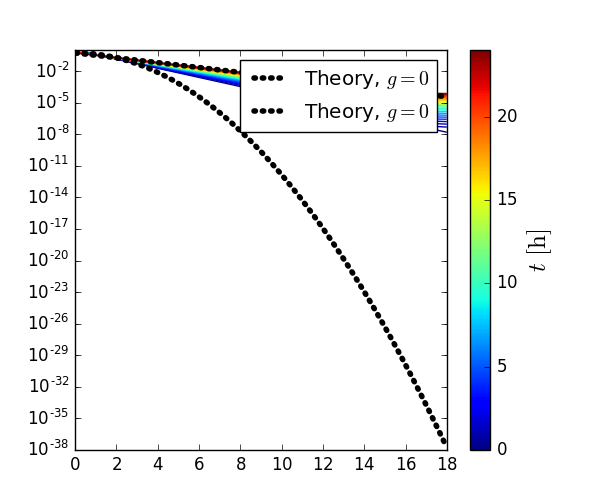

<IPython.core.display.Javascript object>


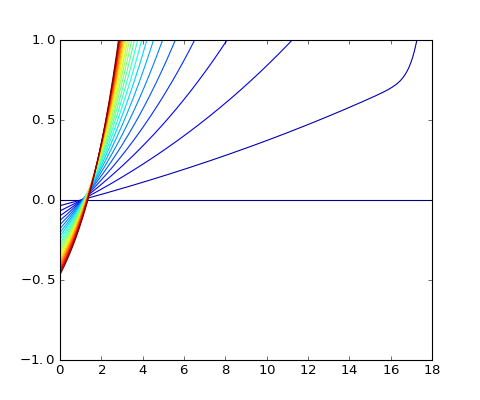

<IPython.core.display.Javascript object>


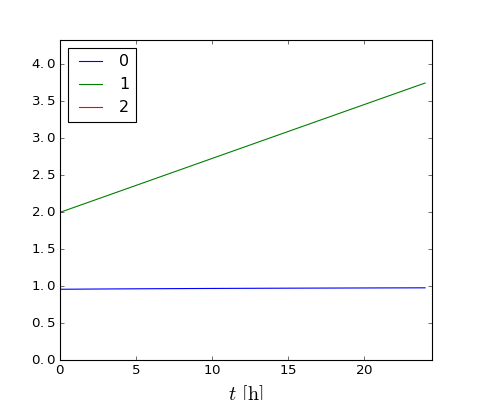

(25,) (25, 4)


<IPython.core.display.Javascript object>


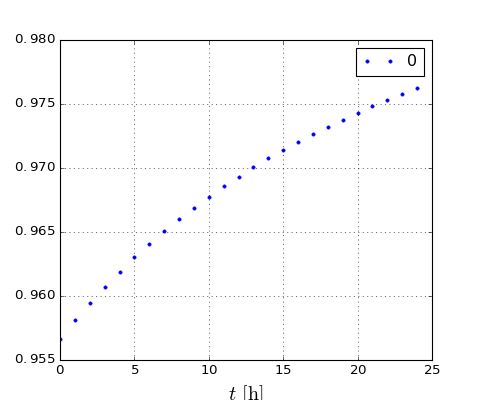

In [532]:
psis=psis1D

# Plotting
time_scale = 1 ;  tlabel=r'$t$ $[\mathrm{sec}]$'
time_scale = 60 ; tlabel=r'$t$ $[\mathrm{min}]$'
time_scale = 3600 ; tlabel=r'$t$ $[\mathrm{h}]$'

nplots=100
plot_sep = int(np.ceil(np.size(ts)/nplots))
print('nt=%d , nplots=%d -> plot_sep=%d'%(nt,nplots,plot_sep))

fig1, ax1 = plt.subplots(dpi=100)
norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])


fig2 = plt.figure()
ax2 = plt.gca()


moments = np.zeros((ts.size,4))
for i , t in enumerate(ts):
    if discretization_scheme==1:
        moments[i,:] = [simp(r,r*psis[i,:] *r**j,discretization_scheme==2) for j in [0,1,2,3]]
    elif discretization_scheme==2:
        moments[i,:] = [trapezoidal(rEdge,r*psis[i,:] *r**j,discretization_scheme==2) for j in [0,1,2,3]]
    if Dnr ==5:
        moments[i,:] = [trapezoidal(r,psis[i,:] *(2*r)**(j),0) for j in [0,1,2,3]]

    if i%plot_sep==0:
        ax1.plot(r,psis[i,:], c=cmap.to_rgba(t/time_scale))
        ax2.plot(r,(psis[i,:]-psis[0,:])/psis[0,:], c=cmap.to_rgba(t/time_scale))
    
#         print(t/time_scale,np.sum(dr*r*psis[i,:]),np.sum(dr*r*r**2*psis[i,:]))
ax1.set_yscale('log')
cb=fig1.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# Theoretical curve
D = Deq+Dibs # DD(r,1,Deq)*1+Dibs
psitheory = 1/(sig**2 + 2*D*tmax)*np.exp(-0.5*r**2/(sig**2 + 2*D*tmax))
ax1.plot(r,psitheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
if Dnr==5:
    sigt=(sig**2+2*D*tmax)
    psiJtheory = 1/sigt*np.exp(-r/sigt)
    ax1.plot(r,psiJtheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
ax1.legend()

ax2.set_ylim([-1,1])

plt.figure()
print(ts.shape,moments.shape)
for i in range(3):
    
    plt.plot(ts/time_scale,moments[:,i],label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)

plt.figure()
for i in range(1):
    plt.plot(ts/time_scale,moments[:,i],'.',label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)


# Plot preders
if Dnr!=5:
    plot_preDers(r,Dnr,Deq,Dibs,1,psis[-1,:])
# plot_preDers(r,Dnr,Deq,Dibs,1,psi)
plt.grid(True)

In [286]:
ANoise=1e-4
frev = 11245
0.5*ANoise**2*frev*3600

0.20240999999999998

In [152]:
print(A1.shape,A2.shape)
print(A12D.shape,A22D.shape)
print(x.shape,y.shape,r.shape)
# print(A1*1e6)
# print(A2*1e6)
# print(A12D[:8,:8]*1e6)
# print(A22D[:8,:8]*1e6)
# print(psi0)
# print(psi02D.T)

print(psi0)
psi1 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,A1,A2))
print(psi02D.T[0,:Nx].shape)
psi2 = sc.integrate.odeint(dpsidt2D,psi02D.T[0,:Nx],ts,args=(x,y,A12D[:Nx,:Nx],A22D[:Nx,:Nx]))
psi3 = sc.integrate.odeint(dpsidt2D,psi02D.T[0],ts,args=(x,y,A12D,A22D))

print(ts)
print(psi1)
print(psi2)
print('ic',np.all(psi0==psi02D.T[0,:Nx]))
print(np.all(psi1==psi2))
print(psi3[:,:Nx])


A2D= A12D+A22D
A1D= A1 + A2
print(np.all(A2D[:Nx,:Nx]==A1D))

plt.figure()
plt.imshow(A12D+A22D,cmap='bwr')




(201, 201) (201, 201)


NameError: name 'A12D' is not defined

# 2D diffusion

In [1028]:

ax = 1e-4
bx = -ax*190/260 * 1
ay=ax ; by=bx
# ay=by=0
g = 0.02
g2 = g/2
Qs = 0.002

QxIns = bx * 2 #JxQres
QyIns = by * 2

Jxavg = 1
Jyavg = 1

def fQx(Jx,Jy,a=ax,b=bx):
    return a*Jx + b*Jy
def fQy(Jx,Jy,a=ay,b=by):
    return b*Jx + a*Jy

def DD2D(x,y,Dnr,Deqx=1,Deqy=1,Jxavg = 1,Jyavg = 1):
    Dx = np.zeros_like(x)
    Dx[:] = np.nan
    Dy = np.zeros_like(x)
    Dy[:] = np.nan
    
    if Dnr == 1:
        D[:] = Deq
    elif Dnr == 2:
        
        dqx = ax * (0.5*x**2-Jxavg) + bx * (0.5*y**2-Jyavg)
        dqy = by * (0.5*x**2-Jxavg) + ay * (0.5*y**2-Jyavg)
        dmux = pi2*dqx
        dmuy = pi2*dqy
        c2 = (1-g2) 
        c3 = g2**2
        Dx[:] = Deq * c2**2*dmux**2 / (c3 + c2*dmux**2)
        Dy[:] = Deq * c2**2*dmuy**2 / (c3 + c2*dmuy**2)
    elif Dnr == 4:
        qx = ax * (0.5*x**2) + bx * (0.5*y**2)
        qy = by * (0.5*x**2) + ay * (0.5*y**2)
#         Qxavg = fQx(Jxavg,Jyavg)
#         Qyavg = fQy(Jxavg,Jyavg)
#         QxIns=Qxavg-Qs
#         QyIns=Qyavg-Qs
#         JxQres = 1
#         Jxavg  =3

        varQ2= 2*(0.4*max(ax,ay))**2

        Dx,Dy = DD2D(x,y,2,Deqx,Deqy,Jxavg,Jyavg)
        Dx[:] *= (1+20*np.exp(-(qx-QxIns)**2/varQ2))
        Dy[:] *= (1+20*np.exp(-(qy-QyIns)**2/varQ2))
    
    else:
        print('This Diffusion coefficient is not implemented')
    return Dx,Dy

def derDD2D(x,y,Dnr,Deqx=1,Deqy=1,Jxavg = 1,Jyavg = 1):
    derDx = np.zeros_like(x)
    derDx[:] = np.nan
    derDy = np.zeros_like(x)
    derDy[:] = np.nan
    if Dnr == 1:
        derDx[:] = 0
        derDy[:] = 0
    elif Dnr == 2 :
        
        dqx = ax * (0.5*x**2-Jxavg) + bx * (0.5*y**2-Jyavg)
        dqy = by * (0.5*x**2-Jxavg) + ay * (0.5*y**2-Jyavg)
        dmux = pi2*dqx
        dmuy = pi2*dqy
        
        ddqxdx = ax * (x)
        ddqydy = ay * (y)
        
        ddmuxdx = pi2*ddqxdx
        ddmuydy = pi2*ddqydy
        
        c2 = (1-g2) 
        c3 = g2**2
        derDx[:] = Deq * c2**2 * c3 * 2*dmux/(c3 + c2*dmux**2)**2 * ddmuxdx
        derDy[:] = Deq * c2**2 * c3 * 2*dmuy/(c3 + c2*dmuy**2)**2 * ddmuydy
    elif Dnr==4:
        derDx[:] = (DD2D(x+eps,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)[0]-DD2D(x-eps,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)[0])/(2*eps)
        derDy[:] = (DD2D(x,y+eps,Dnr,Deqx,Deqy,Jxavg,Jyavg)[1]-DD2D(x,y-eps,Dnr,Deqx,Deqy,Jxavg,Jyavg)[1])/(2*eps)
    else:
        print('This Diffusion coefficient is not implemented')
    
    return derDx,derDy

def preDers2D(x,y,Dnr,Deqx,Deqy,Dibsx,Dibsy,bool_timeDependent=False,psi=0,Jxavg=Jxavg,Jyavg=Jyavg):
    
    if bool_timeDependent:
        print('Not ready for time dependent in 2D')
#         Jxavg = simp(r,0.5*r**2 *r*psi)
#         print('Avg Jx = %.2f'%Jxavg)
    
    preDer2x,preDer2y = DD2D(x,y,Dnr,Deqx,Deqy,Jxavg ,Jyavg )
    preDer2x += Dibsx   ;   preDer2y += Dibsy
    
    
    preDer1ax,preDer1ay = derDD2D(x,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)
#     if r[0]==0:
#         print(preDer2x.shape,x.shape)
#         preDer1bx = np.concatenate(([[0]],preDer2x[1:]/x[1:]))
#         preDer1by = np.concatenate(([[0]],preDer2y[1:]/y[1:]))
#     else:
    preDer1bx = preDer2x/x  ; preDer1bx[x==0] = 0
    preDer1by = preDer2y/y  ; preDer1by[y==0] = 0
    preDer1x = preDer1ax + preDer1bx
    preDer1y = preDer1ay + preDer1by
    
    
#     preDer1x = preDer1x[:,np.newaxis]  ; preDer2x = preDer2x[:,np.newaxis]  
#     preDer1y = preDer1y[:,np.newaxis]  ; preDer2y = preDer2y[:,np.newaxis]  
    return preDer1x, preDer2x,preDer1y, preDer2y

def trapezoidal2D(x,y,f):
    dx=x[1]-x[0]
    dy=y[1]-y[0]
    return dx*0.5*dy*0.5*(np.sum(f[1:,:]+f[:-1,:])+np.sum(f[:,1:]+f[:,:-1]))

def trapezoidal2Dproj(x,y,f):
    dy=y[1]-y[0]
    res=np.zeros_like(x)
    for i,ix in enumerate(x):
        res[i] = simp(y,y*f[:,i])
    return res

In [1029]:
Dnr = 4
bool_timeDependent= False
bool_IncoNoise = 0
#################################
### Initiate Space Separation ###
Lx = 5
Ly = Lx
Nx = 31
Ny = Nx
N2 = Nx*Ny

x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
dx= np.diff(x)[0]
dy= np.diff(y)[0]

f_lhc = 11245
noise = 1e-4
Deq=0.5*noise**2*f_lhc # Coherent diffusion noise 
# Deq = 1
Deqx = Deq
Deqy = Deq

Dibsx= Dibsy = Deq*0.001*bool_IncoNoise        # Incoherent diffusion noise: Intra beam scattering


# upwind = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
# dnwind = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
# upwind2= ( 3*np.eye(Nr) -4*np.eye(Nr,k=-1)+np.eye(Nr,k=-2))/(2*dr)
# dnwind2= (-3*np.eye(Nr) +4*np.eye(Nr,k=1) -np.eye(Nr,k=2))/(2*dr)
# upwind2[:2,:2]  =upwind[:2,:2] ; dnwind2[-2:,-2:]=dnwind[-2:,-2:]
# centered=(np.eye(Nr,k=1)-np.eye(Nr,k=-1))/(2*dr)
# preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,0)[:2]
# vp = (preDer1<0)
# vm = (preDer1>0)

# der1 = (upwind2*vp + dnwind2*vm)
# der1= centered
der1xc = (np.eye(N2,k=1)-np.eye(N2,k=-1))/(2*dx)
der1yc = (np.eye(N2,k=Nx)-np.eye(N2,k=-Nx))/(2*dy)

der1x = der1xc
der1y = der1yc

der2x = (np.eye(N2,k=-1)+np.eye(N2,k=1)-2*np.eye(N2))/(dx**2)
der2y = (np.eye(N2,k=-Nx)+np.eye(N2,k=Nx)-2*np.eye(N2))/(dy**2)
        
#left reflective
der2x[0:N2:Nx,1:N2:Nx]*=2
der2x[Nx:N2:Nx,(Nx-1):N2:Nx]=0
der1x[0:N2:Nx,:]=0
#right reflective
der2x[(Nx-1):N2:Nx,(Nx-2):N2:Nx]*=2
der2x[(Nx-1):N2:Nx,(Nx-0):N2:Nx]=0
der1x[Nx-1:N2:Nx,:]=0
#bottom reflective
der2y[0:Nx:1,Nx:2*Nx:1]*=2
der1y[0:Nx,:]=0
#top reflective
der2y[N2-Nx:N2:1,N2-2*Nx:N2-Nx:1]*=2
der1y[N2-Nx:N2,:]=0    

# Coordinates and IC
X,Y= np.meshgrid(x,y)
xx = X.reshape((N2,1))
yy = Y.reshape((N2,1))
psi02D = np.exp(-0.5*xx**2-0.5*yy**2)
C = 1
dt = min(dx**2/Deqx,dy**2/Deqy)*C
Nt = 100
Nt = int(Nt/100)+1 ;  dt *= 100
ts = np.arange(Nt)*dt
Nt = 13
ts = np.linspace(0,12*3600,Nt)
if g==0: ts=ts/100

preDer2x = np.ones((N2,1))*Deqx
preDer2y = np.ones((N2,1))*Deqy
preDer1x = preDer2x/xx ; preDer1x[np.isinf(preDer1x)]=0
preDer1y = preDer2y/yy ; preDer1y[np.isinf(preDer1y)]=0
preDer1x, preDer2x, preDer1y, preDer2y = preDers2D(xx,yy,Dnr,Deqx,Deqy,Dibsx,Dibsy,bool_timeDependent)

A12D = preDer1x*der1x + preDer1y*der1y
A22D = preDer2x*der2x + preDer2y*der2y

def dpsidt2D(psi,t,x=x,y=y,A1=A12D,A2=A22D):
    return (A1+A2).dot(psi)


print('Nx=%d , Ny=%d -> NxNy=%d'%(Nx,Ny,N2))
print('Nt',Nt)
print('dt',dt)
print('tmax [h]',np.max(ts)/3600)
print(X[0,2])
# print(preDer2y.T*1e6)
print(np.max(preDer1y)*1e9,np.max(preDer2y)*1e9)
print(preDer1x[:15].T*1e6)
print(preDer2x[:15].T*1e6)
print(der1x[:8,:8])
print(der2x[:8,:8])

Nx=31 , Ny=31 -> NxNy=961
Nt 13
dt 49404.6736821
tmax [h] 12.0
0.333333333333
89442.2093184 20536.7337663
[[ 0.     0.068 -0.002 -0.023 -0.013  0.03   0.112  0.24   0.421  0.661
   0.967  1.343  1.794  2.321  2.925]]
[[ 0.016  0.014  0.01   0.005  0.     0.001  0.012  0.037  0.083  0.159
   0.271  0.43   0.644  0.924  1.279]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  0.  3.  0.  0.  0.  0.  0.]
 [ 0. -3.  0.  3.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  3.  0.  0.  0.]
 [ 0.  0.  0. -3.  0.  3.  0.  0.]
 [ 0.  0.  0.  0. -3.  0.  3.  0.]
 [ 0.  0.  0.  0.  0. -3.  0.  3.]
 [ 0.  0.  0.  0.  0.  0. -3.  0.]]
[[-72.  72.   0.   0.   0.   0.   0.   0.]
 [ 36. -72.  36.   0.   0.   0.   0.   0.]
 [  0.  36. -72.  36.   0.   0.   0.   0.]
 [  0.   0.  36. -72.  36.   0.   0.   0.]
 [  0.   0.   0.  36. -72.  36.   0.   0.]
 [  0.   0.   0.   0.  36. -72.  36.   0.]
 [  0.   0.   0.   0.   0.  36. -72.  36.]
 [  0.   0.   0.   0.   0.   0.  36. -72.]]


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:108: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:109: RuntimeWarning: divide by zero encountered in true_divide


In [1030]:
psis = sc.integrate.odeint(dpsidt2D,psi02D.T[0],ts,args=(x,y,))
psis2D=psis

0.0772404311251
0.0772748791388
(961, 1) (961, 1) (961,)


<IPython.core.display.Javascript object>


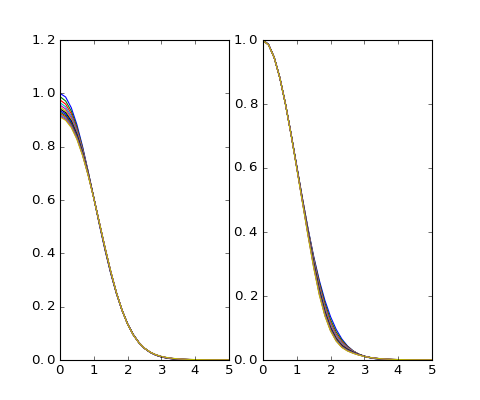

t=0.00: N=1.00, Jx=1.00, Jy=1.00
t=1.00: N=1.00, Jx=1.01, Jy=1.01
t=2.00: N=1.00, Jx=1.01, Jy=1.01
t=3.00: N=1.00, Jx=1.02, Jy=1.02
t=4.00: N=1.00, Jx=1.03, Jy=1.03
t=5.00: N=1.00, Jx=1.03, Jy=1.03
t=6.00: N=1.00, Jx=1.04, Jy=1.04
t=7.00: N=1.00, Jx=1.05, Jy=1.05
t=8.00: N=1.00, Jx=1.06, Jy=1.06
t=9.00: N=1.00, Jx=1.06, Jy=1.06
t=10.00: N=1.00, Jx=1.07, Jy=1.07
t=11.00: N=1.00, Jx=1.08, Jy=1.08
t=12.00: N=1.00, Jx=1.08, Jy=1.08
[  0.      0.014   0.056   0.125   0.222   0.347   0.5     0.681   0.889
   1.125   1.389   1.681   2.      2.347   2.722   3.125   3.556   4.014
   4.5     5.014   5.556   6.125   6.722   7.347   8.      8.681   9.389
  10.125  10.889  11.681  12.5  ]


In [1031]:
psis=psis2D
print(simp(x,x*np.average(psis[0,:].reshape((Ny,Nx)),axis=0,weights=y)))
print(simp(x,x*np.average(psis[-1,:].reshape((Ny,Nx)),axis=0,weights=y)))
print(xx.shape,yy.shape,psis[0,:].shape)
fig,axs=plt.subplots(1,2)

for i,t in enumerate(ts):
    norm = trapezoidal2D(x,y,X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    Jx   = trapezoidal2D(x,y,0.5*X**2*X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    Jy   = trapezoidal2D(x,y,0.5*Y**2*X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    print('t=%2.2f: N=%.2f, Jx=%.2f, Jy=%.2f'%(t/3600,norm,Jx,Jy))
    
    xproj=trapezoidal2Dproj(x,y,psis[i,:].reshape((Ny,Nx)))
    axs[0].plot(x,xproj)#psis[i,0*Nx:1*Nx])
    yproj=trapezoidal2Dproj(y,x,psis[i,:].reshape((Ny,Nx)).T)
    axs[1].plot(x,psis[i,:Nx]) #.reshape(Ny,Nx),axis=1)
#     axs[1].plot(y,yproj)
print(.5*x**2)


<IPython.core.display.Javascript object>


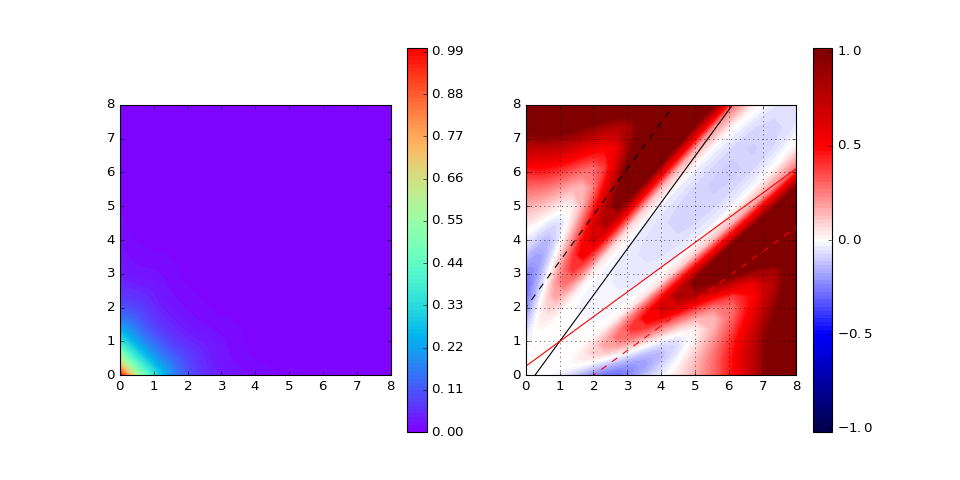

<IPython.core.display.Javascript object>


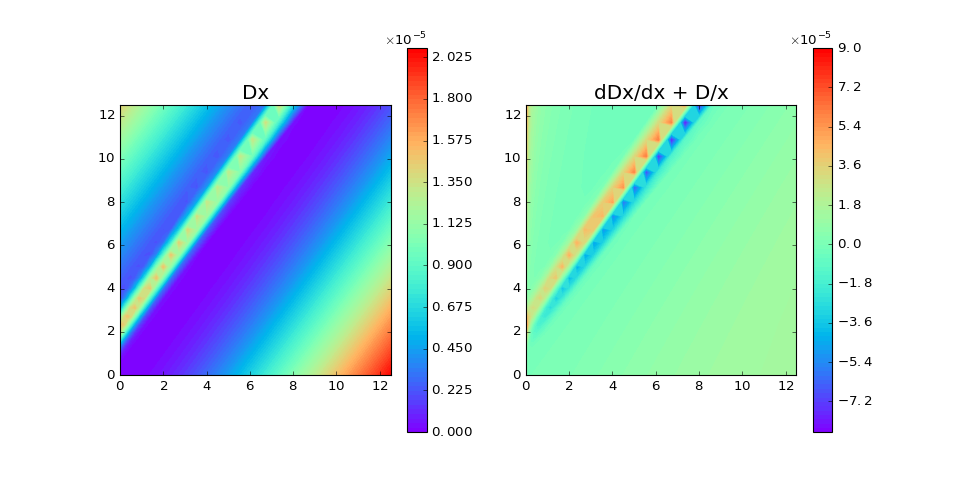

<IPython.core.display.Javascript object>


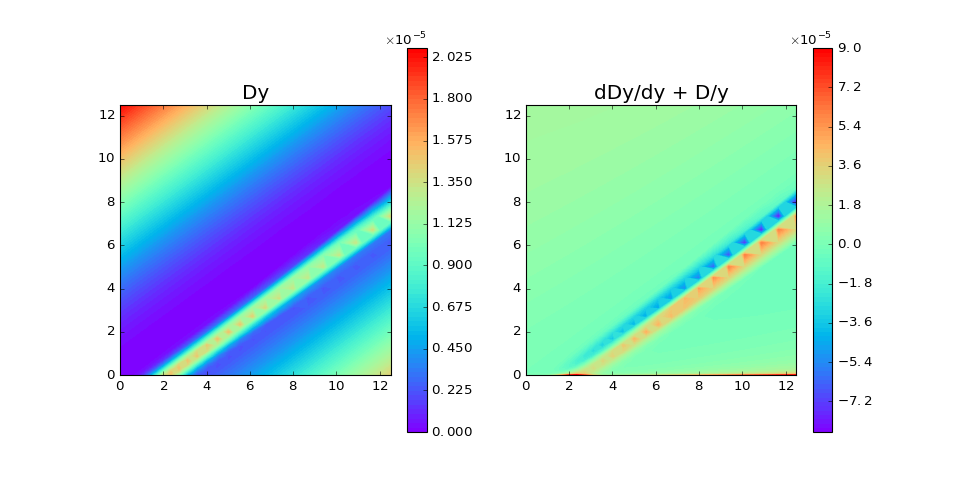

In [1032]:
# Distribution

it = 5

fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,psis[it,:].reshape((Ny,Nx)),100,vmin=0,vmax=1)
plt.colorbar()
jmax=8
ax1.axis([0,jmax,0,jmax])

ax2= fig.add_subplot(122,aspect='equal')
# plt.contourf(.5*X**2,.5*Y**2,(psis[-1,:]-0*psis[0,:]).reshape((Nx,Ny)),100)
# plt.contourf(.5*X**2,.5*Y**2,((psis[-1,:]-psis[0,:])/psis[0,:]).reshape((Nx,Ny)),np.linspace(-0.1,.1,100))
change = ((psis[it,:]-psis[0,:])/psis[0,:])
maxchange = min(1,np.max(np.abs(change))/3)
levels = np.concatenate(([-1e9],np.linspace(-maxchange,maxchange,100),[1e9]))
cs=plt.contourf(.5*X**2,.5*Y**2,change.reshape((Ny,Nx)),levels,cmap='seismic')
cs.set_clim(-maxchange,maxchange)
ax2.axis([0,jmax,0,jmax])
ax2.grid(True)
cb=plt.colorbar(ticks=np.linspace(-maxchange,maxchange,5))
# cb.ticks()


for i in range(2):
    main = np.array([0,jmax])
    if [ax,ay][i]==0: continue
    
    if i==0:
        plt.plot(-1/ax*(bx*main-(ax*Jxavg+bx*Jyavg)),main,'k')
        plt.plot(-1/ax*(bx*main-QxIns),main,'k--')
    else:
        plt.plot(main,-1/ay*(by*main-(ay*Jyavg+by*Jxavg)),'r') #0 for y diff
        plt.plot(main,-1/ay*(by*main-QyIns),'r--')

# Coefficiencts in x diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer2x.reshape((Ny,Nx)),100)
plt.title('Dx')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer1x.reshape((Ny,Nx)),100)
plt.title('dDx/dx + D/x')
plt.colorbar()

# Coefficiencts in y diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer2y.reshape((Ny,Nx)),100)
plt.title('Dy')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer1y.reshape((Ny,Nx)),100)
plt.title('dDy/dy + D/y')
plt.colorbar()




In [1021]:
# print(xx.reshape((Nx,Ny)),yy.T)
print(preDer1x.T*1e6)
print(preDer2x.T*1e9)
print(psi0.T[0])
print(der1x)
print(der1y)
print(der2x)
print(der2y)

[[  0.      0.068  -0.002  -0.023  -0.013   0.03    0.112   0.24    0.421
    0.661   0.967   1.343   1.794   2.321   2.925   3.605   4.356   5.17
    6.037   6.944   7.876   8.814   9.739  10.633  11.477  12.252  12.944
   13.542  14.037  14.424  14.703   0.      0.074  -0.     -0.024  -0.016
    0.026   0.107   0.233   0.413   0.652   0.957   1.332   1.782   2.308
    2.912   3.591   4.342   5.156   6.023   6.931   7.863   8.802   9.728
   10.624  11.468  12.245  12.939  13.538  14.034  14.423  14.703   0.
    0.095   0.005  -0.026  -0.023   0.014   0.091   0.214   0.39    0.625
    0.927   1.299   1.746   2.27    2.872   3.55    4.299   5.113   5.981
    6.89    7.824   8.765   9.695  10.594  11.443  12.224  12.922  13.526
   14.026  14.419  14.703   0.      0.136   0.015  -0.029  -0.034  -0.005
    0.065   0.181   0.351   0.581   0.877   1.244   1.686   2.207   2.805
    3.481   4.229   5.042   5.911   6.821   7.759   8.704   9.64   10.545
   11.4    12.188  12.894  13.505  14.012 

<IPython.core.display.Javascript object>


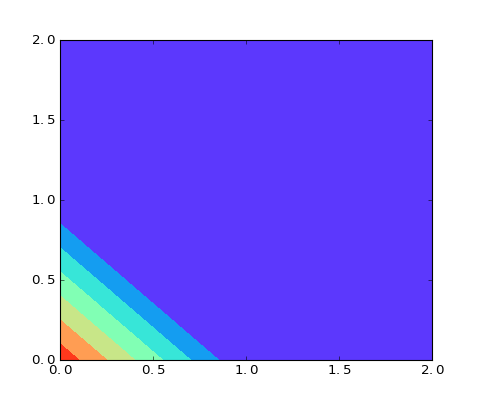

In [277]:
X,Y = np.meshgrid(x,y)
psi0 = np.exp(-0.5*X**2-0.5*Y**2)
plt.figure()
plt.contourf(psi0)

In [199]:
print(N2)

121


# Extra

<IPython.core.display.Javascript object>


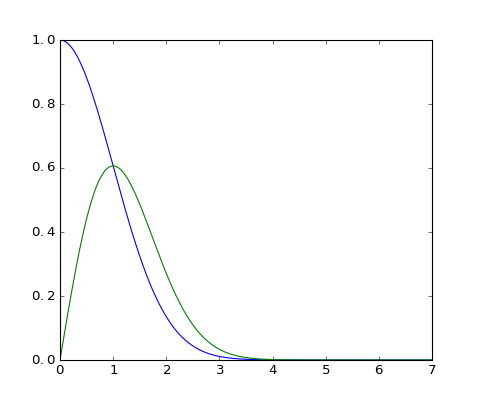

<IPython.core.display.Javascript object>


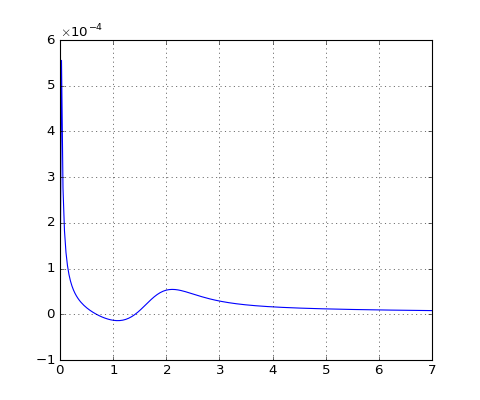

<IPython.core.display.Javascript object>


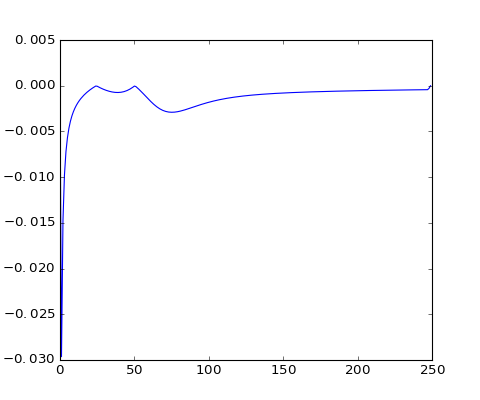

[1 2 3]
3


In [82]:
plt.figure()
plt.plot(r,psi)
plt.plot(r,r*psi)
plt.figure()
plt.plot(r,preDer1)
plt.grid(True)
plt.figure()
plt.plot(A1.diagonal())
# plt.plot(flux2.diagonal())
print(x)
print(x[-1])

In [782]:
Nr=5
Fm = np.eye(Nr,k=0)-np.eye(Nr,k=-1)
r= np.linspace(0,2,Nr)
redge = r[:-1]+np.diff(r)*0.5
Jxavg=1
preDer1Edge = derDD(redge,Dnr,Deq,Jxavg) + DD(redge,Dnr,Deq,Jxavg)/redge

print(Fm[1:]*preDer1Edge[:,np.newaxis])
print(u)
print(r,redge)
print(preDer1Edge)

[[-0.962  0.962  0.     0.     0.   ]
 [-0.     0.067 -0.067 -0.    -0.   ]
 [-0.    -0.     0.189 -0.189 -0.   ]
 [ 0.     0.     0.    -0.64   0.64 ]]
[ 2.    2.25  2.5   2.75  3.  ]
[ 0.   0.5  1.   1.5  2. ] [ 0.25  0.75  1.25  1.75]
[ 0.962 -0.067 -0.189  0.64 ]


In [99]:
if 0:
    # der1 = np.eye(Nr,k=0)-np.eye(Nr,k=-1)
    ve = np.arange(-2,2)
    ve = np.ones(Nr-1) #np.linspace(-2,2,Nr-1)
    v= np.concatenate(([0],ve,[0]))

    vp = v>0
    vn = v<0
    vvp=(v*vp)[np.newaxis,1:]
    vvm=(v*vn)[np.newaxis,:-1]
    upwind = np.eye(Nr) - np.eye(Nr,k=-1)
    dnwind = np.eye(Nr) - np.eye(Nr,k=1)
    flux2 = -(upwind)*(vvp) \
            +(dnwind)*(vvm)

    flux=  np.diag((v*vp)[1:-1],k=-1) - np.diag((v*vp)[1:],k=0) \
     - np.diag((v*vn)[1:-1],k= 1) + np.diag((v*vn)[:-1],k=0) 


    print(v)
    print(upwind)
    print(dnwind)
    print(flux)
    print(flux2)

In [208]:
n1=27
n2=33
print(r[n1])
print(der1[n1:n2,n1:n2])
print(dnwind[n1:n2,n1:n2])
print(upwind[n1:n2,n1:n2])
print(A1[n1:n2,n1:n2]*1e7)
print(preDer1Edge[n1:n2]*1e9)

1.26845637584
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  

In [792]:
aa = np.ones((3,3))
bb = np.arange(3)
print(aa*bb[:,np.newaxis])
print(aa*bb[np.newaxis,:])

[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]
[[ 0.  1.  2.]
 [ 0.  1.  2.]
 [ 0.  1.  2.]]


<IPython.core.display.Javascript object>


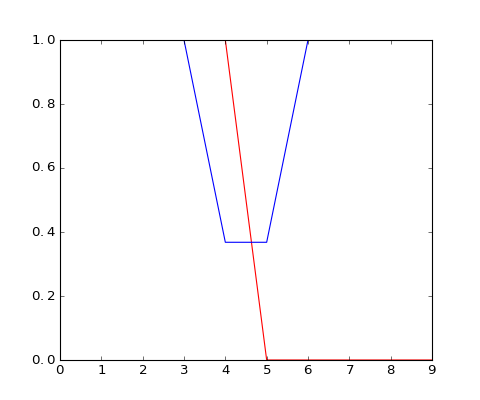

In [946]:


x = np.linspace(-4,4,15)
x = np.exp(-x**2)
x = np.ones(10)
x[5:] =0
plt.figure()
plt.plot(x,'r')
plt.plot(limiter(x))

In [227]:
a = np.arange(3)[:,np.newaxis]
# a = np.arange(3)
b = np.ones((3,3))
print(a.T)
print(b*a)

[[0 1 2]]
[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]


# How to use odeint

In [175]:
Nr = 100
u = 1
def dydx(y,t,x):
    dx = np.diff(x)[0]
    A = (np.eye(Nr,k=1)+np.eye(Nr,k=-1)-2*np.eye(Nr))/dx**2
    return A.dot(y)

def dydx2(y,t,x):
    dx = np.diff(x)[0]
    A = -u*(np.eye(Nr,k=0)-np.eye(Nr,k=-1))/dx
    A[0,-1]=-A[0,0]
    
    return A.dot(y)

x = np.linspace(0,10,Nr)
y0 = np.exp(-(x-5)**2)

dt = .51*np.diff(x)[0]
t = np.arange(20)*dt

out = np.zeros((np.size(t),np.size(y0)))
for i,it in enumerate(t):
    if i==0: 
        out[i]=y0
    else:
        out[i] = out[i-1]+dt*dydx2(out[i-1],it,x)
    
# out=sc.integrate.odeint(dydx2,y0,t,args=(x,))

<IPython.core.display.Javascript object>


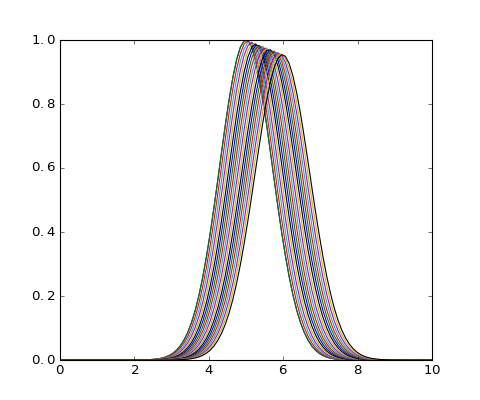

In [176]:
plt.figure()
plt.plot(x,y0)
plt.plot(x,out.T)

In [159]:
A= np.ones((4,4))*np.arange(4)
b = np.arange(4)

In [162]:
print(A*b)
print(A.dot(b))

[[ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]]
[ 14.  14.  14.  14.]


# Test integration

22.0 22.0 21.3333333333


<IPython.core.display.Javascript object>


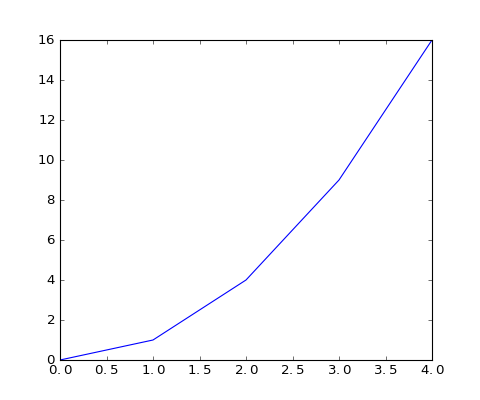

In [162]:
x = np.array([0,1,2,3,4])
y = np.array([0,1,4,9,16])


print(np.trapz(y,x),trapezoidal(x,y),simp(x,y))
plt.figure()
plt.plot(x,y)